In [10]:
import numpy as np
import astropy.constants as const
from scipy.integrate import tplquad, nquad
import matplotlib.pyplot as plt
import yaml
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.colors as colors

# Physical constants (cgs units)
m_e = (const.m_e.cgs).value  # electron mass (g)
c = (const.c.cgs).value    # speed of light (cm/s)
e = (const.e.esu).value   # electron charge (esu)

# parameters
out_dir = '/home/wsy/Acc_MC/num_sols/results/'
with open('/home/wsy/Acc_MC/MC_sim/paras.yaml', 'r') as f:
    config = yaml.safe_load(f)
R_sh = float(config['R_sh'])
GM0 = float(config['GM0'])
eta = float(config['eta'])
beta_min = float(config['beta_min'])
B0 = float(config['B0'])
xi = float(config['xi'])
Lam_max = float(config['Lam_max'])
g_me0 = float(config['g_me0']) 
r0 = float(config['r0'])
n_p = float(config['n_p'])

N_par = int(config['N_par']) # 粒子数
N_time = int(float((config['N_time']))) # 时间步数
N_bins = int(config['N_bins']) # 时间步长
Nu = int(config['N_grids']) # 格点数

jet_type = str(config['type'])
syn = bool(config['SYN_flag'])
SA = bool(config['SA_flag'])
Sh = bool(config['Shear_flag'])
ESC = bool(config['ESC_flag'])

if jet_type=='kolgv': 
    q = 5/3
elif jet_type=='Bohm':
    q = 1
elif jet_type=='HS':
    q = 2

def beta_dis(r):
    beta_max = np.sqrt(1-1/GM0**2)
    r1 = eta*R_sh
    if (r < r1):
        return beta_max
    elif (r > R_sh):
        return 0.0
    else: 
        return beta_max-(beta_max-beta_min)/(R_sh-r1)*(r-r1)

def tau(gamma):
    rg = gamma * m_e * c**2 / (e * B0)
    return (rg**(2 - q) / (c * xi)) * Lam_max**(q - 1)

def Delta_r(gamma, theta, phi, alpha):
    
    beta = np.sqrt(1 - 1/gamma**2)
    t = tau(gamma)
    r = r0
    term1 = r**2
    term2 = 2 * beta * c* r * t * np.sin(theta) * np.cos(alpha - phi)
    term3 = (beta * c * np.sin(theta) * t)**2
    dr = np.sqrt(term1 + term2 + term3) - r
    return dr

def beta_Delta(gamma, theta, phi, alpha):
    beta0 = np.sqrt(1-1/GM0**2)
    Delta_L = (1-eta)*R_sh
    Delta_beta_j = ((beta_min-beta0) / Delta_L) * Delta_r(gamma, theta, phi, alpha)
    beta_j = beta_dis(r0)
    Gamma_j = 1/(np.sqrt(1-beta_j**2))
    return Gamma_j**2 * Delta_beta_j*(1 + Gamma_j**2 * Delta_beta_j * beta_j)

def Gamma_Delta(gamma, theta, phi, alpha):
    b_Delta = beta_Delta(gamma, theta, phi, alpha)
    return 1 + 0.5 * b_Delta**2

def gamma_prime(gamma, theta, phi, alpha):
    beta = np.sqrt(1 - 1/gamma**2)
    b_Delta = beta_Delta(gamma, theta, phi, alpha)
    G_Delta = Gamma_Delta(gamma, theta, phi, alpha)
    alt = gamma*(1 + 0.5*b_Delta**2 - beta*b_Delta*np.cos(theta))
    return alt #G_Delta * gamma * (1 - beta * b_Delta * np.cos(theta))

def integrand(theta, phi, alpha, gamma):
    """Integrand: (gamma' - gamma)^2 * sin(theta)"""
    gp = gamma_prime(gamma, theta, phi, alpha)
    return (gp - gamma) * np.sin(theta)

def energy_change_rate(gamma):
    t = tau(gamma)
    # Triple integral over theta: [0, pi], phi: [0, 2pi], alpha: [0, 2pi]
    '''integral, _ = tplquad(
        lambda theta, phi, alpha: integrand(theta, phi, alpha, gamma),
        0, 2*np.pi,  # alpha limits
        0, 2*np.pi,  # phi limits
        0, np.pi     # theta limits
    )'''
    integral, _ = nquad(
        lambda alpha, phi, theta: integrand(theta, phi, alpha, gamma),
        ranges=[[0, 2*np.pi], [0, 2*np.pi], [0, np.pi]],
        opts={'epsabs': 1e-6, 'epsrel': 1e-4, 'limit': 1000}
        )
    return (2 * integral) / (8 * np.pi**2 * t)

# Compute for a range of gamma values
gamma_values = np.logspace(1, 10, 20)  # gamma from 10^2 to 10^5
rates = [energy_change_rate(g) for g in gamma_values]
#print(rates)

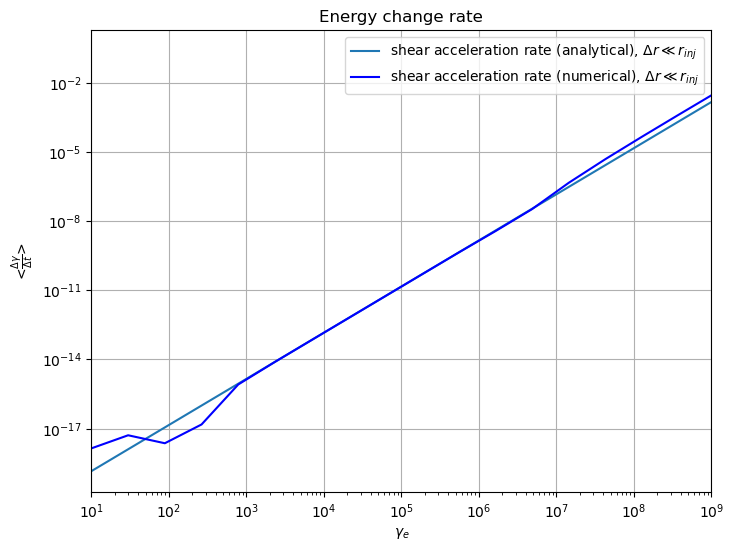

In [11]:
def T_sh(B0,gme):
    beta0 = beta_dis(0) #中心流速
    beta = beta_dis(r0) #注入位置流速
    rate = 1- eta # 剪切区域比例
    Delta_r = rate*R_sh
    A_sc = xi**(-1)*Lam_max**(q-1)*c**(-1)*(m_e*np.square(c)/(e*B0))**(2-q)
    Gamma_j4 = 1/(1-beta**2)**2
    A1=(2/15)*Gamma_j4*np.square(c*(beta0/Delta_r))*A_sc
    t_sh = 2*gme**(q-2)/(A1*(6-q))
    return t_sh

t_sh = T_sh(B0,gamma_values)
plt.figure(figsize=(8,6))
plt.title('Energy change rate')
plt.plot(gamma_values,gamma_values/t_sh,label=r'shear acceleration rate (analytical), $\Delta r \ll r_{inj}$')
plt.plot(gamma_values, rates, 'b-', label=r'shear acceleration rate (numerical), $\Delta r \ll r_{inj}$')
#plt.plot(gmes[0:-1], avg_energy_rate_list, label='MC sim')
plt.xscale('log')
plt.yscale('log')
plt.xlabel(r'$\gamma_e$')
plt.ylabel(r'<$\frac{\Delta \gamma}{\Delta t}$>')
plt.grid(True)
xmin = 1e1
xmax = 1e9
plt.xlim(xmin,xmax)
#plt.ylim(1e-13,1e-10)
plt.legend()
plt.show()

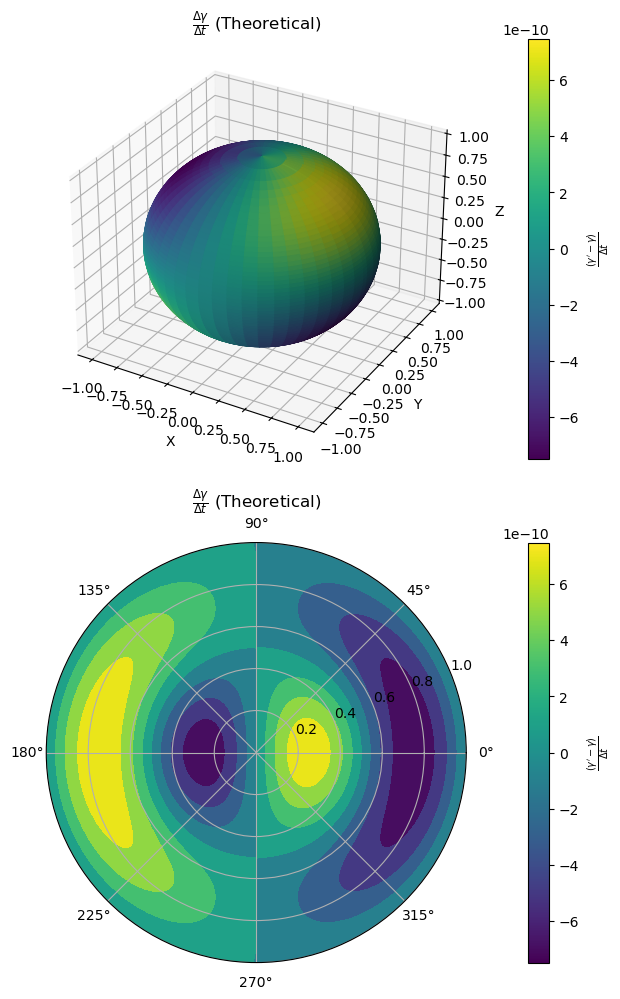

In [12]:
gme0 = 10
# 考虑在球坐标系下每个方向的加速:
theta_list = np.arccos(np.linspace(-1,1,100))
alpha_list = np.linspace(0, 2*np.pi, 100)
results = np.zeros((len(theta_list),len(alpha_list)))
for i in range(len(theta_list)):
    for j in range(len(alpha_list)):
        gamma_p = gamma_prime(gme0, theta_list[i], 0, alpha_list[j])
        delta_gm = (gamma_p - gme0)/tau(gme0)
        results[i,j] = delta_gm


# 三维
Theta, Alpha = np.meshgrid(theta_list, alpha_list, indexing='ij')
X = np.sin(Theta)*np.cos(Alpha)
Y = np.sin(Theta)*np.sin(Alpha)
Z = np.cos(Theta)
norm = colors.TwoSlopeNorm(vmin = results.min(),vcenter = 0, vmax=results.max())

fig = plt.figure(figsize = (16,12))
ax1 = fig.add_subplot(211, projection = '3d')
ax1.set_title(r'$\frac{\Delta \gamma}{\Delta t}$ (Theoretical)')
ax1.set_xlabel('X')
ax1.set_ylabel('Y')
ax1.set_zlabel('Z')
surf1 = ax1.plot_surface(X, Y, Z, facecolors = cm.viridis(norm(results)))

# color bar
mapp = cm.ScalarMappable(norm = norm, cmap = cm.viridis)
mapp.set_array(results)
cbar = plt.colorbar(mapp, ax = ax1)
cbar.set_label(r'$\frac{(\gamma^{\prime} - \gamma)}{\Delta t}$')

# 二维
ax2 = fig.add_subplot(212,projection = 'polar')
ax2.set_title(r'$\frac{\Delta \gamma}{\Delta t}$ (Theoretical)')
contour = ax2.contourf(Alpha, Theta/(np.pi), results, cmap = 'viridis', norm =norm)
cbar_2d = plt.colorbar(mapp, ax = ax2)
cbar_2d.set_label(r'$\frac{(\gamma^{\prime} - \gamma)}{\Delta t}$')

plt.show()


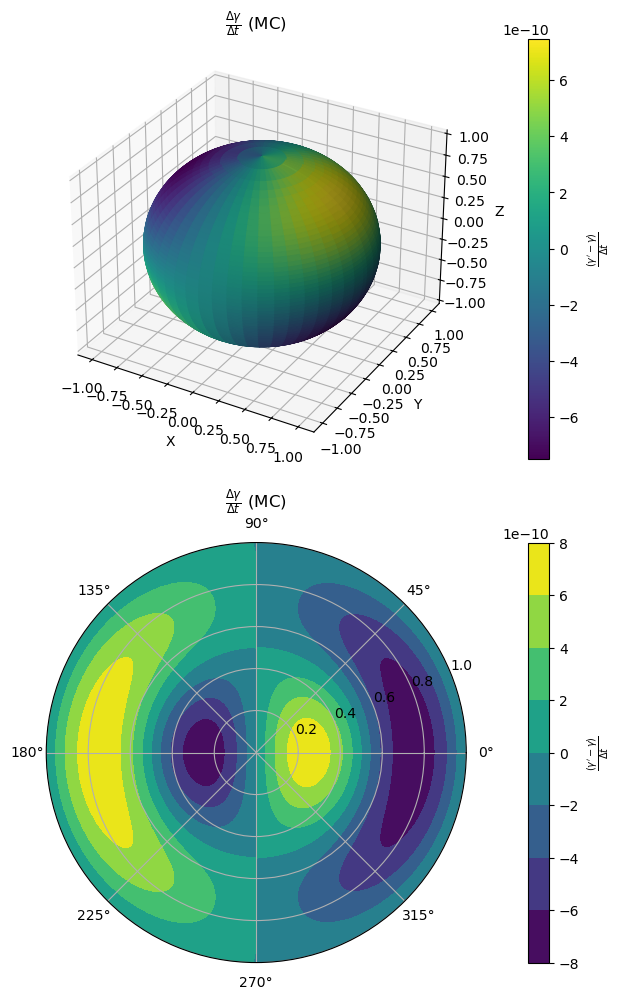

In [13]:
# MC
results_MC = np.zeros((len(theta_list), len(alpha_list)))

def Rg_calc(g_me):
    return np.sqrt(g_me**2)*m_e*c**2/(e*B0)

def tau_calc(g_me):
    return Rg_calc(g_me)**(2-q)*Lam_max**(q-1)*(c*xi)**(-1)
    
def movement_e(g_me,costheta, phi, dt, x, y):
    u_cmv = np.sqrt(1-1/g_me**2)
    sintheta = np.sqrt(1-costheta**2)
    
    ux = u_cmv*sintheta*np.cos(phi)
    uy = u_cmv*sintheta*np.sin(phi)
    #uz = u_cmv*costheta
    
    dx = ux*c*dt
    dy = uy*c*dt
    #dz_jet = uz*c*dt
    x += dx
    y += dy
    
    return x,y

def LorentzGamma(beta1, beta2, costheta, g_me): 
    dbeta = (beta2 - beta1) / (1 - beta1 * beta2)
    #print(dbeta)
    if (dbeta == 0):
        return g_me
    betae =  np.sqrt(1-1/g_me**2)
    dGM = 1.0 / np.sqrt(1 - dbeta**2)
    #print(dGM)
    g_me2 = dGM * g_me * (1 - betae * dbeta * costheta)
    #if (dGM*(1 - betae * dbeta * costheta)<=1):
        #print(dGM*(1 - betae * dbeta * costheta))
    return g_me2

tau0 = tau_calc(gme0)
beta_ini = beta_dis(r0)
for i in range(len(theta_list)):
    for j in range(len(alpha_list)):
        [x0,y0] = [r0*np.cos(alpha_list[j]), r0*np.sin(alpha_list[j])]
        x,y = movement_e(gme0, np.cos(theta_list[i]),0,tau0, x0, y0)
        r_tmp = np.sqrt(x**2 + y**2)
        beta_tmp = beta_dis(r_tmp)
        gamma_p_MC = (LorentzGamma(beta_ini, beta_tmp, np.cos(theta_list[i]), gme0) - gme0)/tau(gme0)
        results_MC[i,j] = gamma_p_MC
        
# 三维
Theta, Alpha = np.meshgrid(theta_list, alpha_list, indexing='ij')
X = np.sin(Theta)*np.cos(Alpha)
Y = np.sin(Theta)*np.sin(Alpha)
Z = np.cos(Theta)
norm = colors.TwoSlopeNorm(vmin = results_MC.min(),vcenter = 0, vmax=results_MC.max())

fig = plt.figure(figsize = (16,12))
ax1 = fig.add_subplot(211, projection = '3d')
ax1.set_title(r'$\frac{\Delta \gamma}{\Delta t}$ (MC)')
ax1.set_xlabel('X')
ax1.set_ylabel('Y')
ax1.set_zlabel('Z')
surf1 = ax1.plot_surface(X, Y, Z, facecolors = cm.viridis(norm(results_MC)))

# color bar
mapp = cm.ScalarMappable(norm = norm, cmap = cm.viridis)
mapp.set_array(results_MC)
cbar = plt.colorbar(mapp, ax = ax1)
cbar.set_label(r'$\frac{(\gamma^{\prime} - \gamma)}{\Delta t}$')

# 二维
ax2 = fig.add_subplot(212,projection = 'polar')
ax2.set_title(r'$\frac{\Delta \gamma}{\Delta t}$ (MC)')
contour = ax2.contourf(Alpha, Theta/(np.pi), results_MC, cmap = 'viridis', norm =norm)
cbar_2d = plt.colorbar(contour, ax = ax2)
cbar_2d.set_label(r'$\frac{(\gamma^{\prime} - \gamma)}{\Delta t}$')

plt.show()

        

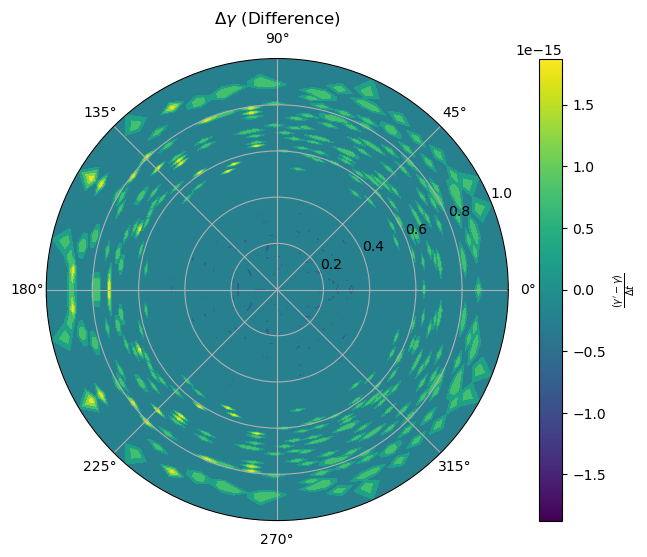

In [14]:
fig = plt.figure(figsize = (8,6))
ax1 = fig.add_subplot(111, projection = 'polar')
ax1.set_title(r'$\Delta \gamma$ (Difference)')
diff = results_MC-results

norm = colors.TwoSlopeNorm(vmin = diff.min(), vcenter= 0 , vmax=diff.max())

# color bar
mapp = cm.ScalarMappable(norm = norm, cmap = cm.viridis)
mapp.set_array(diff)
cbar = plt.colorbar(mapp, ax = ax1)
cbar.set_label(r'$\frac{(\gamma^{\prime} - \gamma)}{\Delta t}$')

contour = ax1.contourf(Alpha, Theta/(np.pi), diff, cmap = 'viridis', norm = norm)

plt.show()